# Tree-based classifier models

| Model | Time taken | Accuracy (weighted avg f1-score) |
|-------|------------|-----------------------------------|
| Decision Tree | 122.0s | 0.45 |
| Extra Tree | 107.6s | 0.42 |
| Random Forest | 36.6s | 0.59 |
| Extra Trees | 7.3s | 0.58 |
| Gradient Boosting | 720.5s | 0.63 |
| Histogram-based Gradient Boosting | 6.1s | 0.64 |
| Bagging Meta-estimator | 60.2s | 0.52 |
| Voting Classifier | 695.7s | 0.61 |
| Stacking Classifier | 3574.2 | 0.61 |
| Isolation Forest | 0.3s | 0.23 |
| AdaBoost | 47.9s | 0.55 |
| XGBoost | 5.8s | 0.64 |
| LightGBM | 31.1s | 0.64 |
| CatBoost | 15.3s | 0.65 |
| NGBoost | 2129.6s | 0.57 |

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

# Individual decision trees
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
# Ensemble methods of decision trees
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
# Gradient boosted decision trees
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
# Other methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import IsolationForest
# Advanced boosting methods
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

# Load pre-trained embeddings
import gensim.downloader as api
glove_vectors = api.load("glove-wiki-gigaword-300")

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

2025-03-23 21:45:27.268199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742737527.285538   46500 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742737527.291039   46500 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 21:45:27.308622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Check GPU

In [2]:
# Check if TensorFlow can see GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# More detailed GPU information
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU name:", gpu.name)
        print("GPU details:", tf.config.experimental.get_device_details(gpu))
else:
    print("No GPU detected. TensorFlow is running on CPU.")

# Simple test to confirm GPU operation
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("Executed on GPU")

TensorFlow version: 2.18.0
Num GPUs Available: 1
GPU name: /physical_device:GPU:0
GPU details: {'compute_capability': (7, 5), 'device_name': 'NVIDIA GeForce GTX 1650 Ti'}
Matrix multiplication result: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Executed on GPU


I0000 00:00:1742737596.001187   46500 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2608 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


## Load and split data

In [3]:
train_df = pd.read_csv("data/train_preprocessed.csv", encoding="ISO-8859-1")
train_set, validation_set = train_test_split(train_df, test_size=0.2, random_state=20250310)

print("Train set size: " + str(len(train_set)))
train_set.head()

Train set size: 21984


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (KmÂ²),Density (P/KmÂ²),expanded_text,clean_text,text_without_stopwords,tokens,lemmatized_tokens,lemmatized_sentence,label
25721,269a1d9936,good morning...did you break 5 digits yet?,good morning.,positive,morning,0-20,New Zealand,4822233,263310.0,18,good morning...did you break 5 digits yet?,good morningdid you break digits yet,good morningdid break digits yet,"['good', 'morningdid', 'you', 'break', 'digits...","['good', 'morningdid', 'you', 'break', 'digit'...",good morningdid you break digit yet,2
27411,878acf5421,i wish you were in my class last year,i wish you were in my class last year,positive,noon,60-70,Albania,2877797,27400.0,105,i wish you were in my class last year,i wish you were in my class last year,wish class last year,"['i', 'wish', 'you', 'were', 'in', 'my', 'clas...","['i', 'wish', 'you', 'be', 'in', 'my', 'class'...",i wish you be in my class last year,2
24261,958eed7410,Have been rolling on the bed for the past 2 ho...,Have been rolling on the bed for the past 2 ho...,neutral,noon,60-70,Seychelles,98347,460.0,214,Have been rolling on the bed for the past 2 ho...,have been rolling on the bed for the past hour...,rolling bed past hours still unable sleep,"['have', 'been', 'rolling', 'on', 'the', 'bed'...","['have', 'be', 'roll', 'on', 'the', 'bed', 'fo...",have be roll on the bed for the past hour stil...,1
16672,09430f45ef,sadly isn`t me. It`s some1 w/ 1 follower 1 u...,sadly isn`t me.,negative,night,70-100,Saint Lucia,183627,610.0,301,sadly is not me. It is some1 w/ 1 follower 1...,sadly is not me it is some w follower update h...,sadly w follower update used twitter since may...,"['sadly', 'is', 'not', 'me', 'it', 'is', 'some...","['sadly', 'be', 'not', 'me', 'it', 'be', 'some...",sadly be not me it be some w follower update h...,0
6925,9849f2c929,LOL how many stalkers today?you just love get...,love,positive,night,31-45,"Eswatini (fmr. ""Swaziland"")",1160164,17200.0,67,LOL how many stalkers today?you just love get...,lol how many stalkers todayyou just love getti...,lol many stalkers todayyou love getting creepy...,"['lol', 'how', 'many', 'stalkers', 'todayyou',...","['lol', 'how', 'many', 'stalker', 'todayyou', ...",lol how many stalker todayyou just love get cr...,2


In [4]:
print("Validation set size: " + str(len(validation_set)))
validation_set.head()

Validation set size: 5496


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (KmÂ²),Density (P/KmÂ²),expanded_text,clean_text,text_without_stopwords,tokens,lemmatized_tokens,lemmatized_sentence,label
7096,d4d73f8bff,"yeah. No vomiting tonight, bit sniffly but ok...","yeah. No vomiting tonight, bit sniffly but ok....",neutral,night,70-100,Canada,37742154,9093510.0,4,"yeah. No vomiting tonight, bit sniffly but ok...",yeah no vomiting tonight bit sniffly but ok be...,yeah vomiting tonight bit sniffly ok bens tryi...,"['yeah', 'no', 'vomiting', 'tonight', 'bit', '...","['yeah', 'no', 'vomit', 'tonight', 'bit', 'sni...",yeah no vomit tonight bit sniffly but ok ben t...,1
17178,86c5e1e0c5,"I feel sick..like don`t wanna get out of bed, ...",sick..,negative,noon,21-30,Paraguay,7132538,397300.0,18,I feel sick..like do not want to get out of be...,i feel sicklike do not want to get out of bed ...,feel sicklike want get bed bothered go work tu...,"['i', 'feel', 'sicklike', 'do', 'not', 'want',...","['i', 'feel', 'sicklike', 'do', 'not', 'want',...",i feel sicklike do not want to get out of bed ...,0
1963,2be8fc0d5c,I`m on my way to see `17 Again`. I`ve wanted ...,I`m on my way to see `17 Again`. I`ve wanted ...,neutral,night,31-45,Italy,60461826,294140.0,206,I am on my way to see '17 Again'. I have want...,i am on my way to see again i have wanted to s...,way see wanted see looong time,"['i', 'am', 'on', 'my', 'way', 'to', 'see', 'a...","['i', 'be', 'on', 'my', 'way', 'to', 'see', 'a...",i be on my way to see again i have want to see...,1
19500,55f9af0b57,Ugh have to report again monday,Ugh,negative,noon,21-30,Gabon,2225734,257670.0,9,Ugh have to report again monday,ugh have to report again monday,ugh report monday,"['ugh', 'have', 'to', 'report', 'again', 'mond...","['ugh', 'have', 'to', 'report', 'again', 'mond...",ugh have to report again monday,0
22302,352e2cdec2,work Yay!,Yay,positive,noon,21-30,Iceland,341243,100250.0,3,work Yay!,work yay,work yay,"['work', 'yay']","['work', 'yay']",work yay,2


## Feature extraction

In [5]:
def document_vector(doc, model):
    # Convert all words to lowercase as GloVe is case-insensitive
    doc = [word.lower() for word in doc]
    # Filter to words in vocabulary
    doc = [word for word in doc if word in model.key_to_index]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in doc], axis=0)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

# Create document vectors for training and validation sets
X_train = np.array([document_vector(doc.split(), glove_vectors) 
                    for doc in tqdm(train_set["lemmatized_sentence"], desc="Processing train data")])
X_val = np.array([document_vector(doc.split(), glove_vectors) 
                  for doc in tqdm(validation_set["lemmatized_sentence"], desc="Processing val data")])

y_train = train_set["label"]
y_val = validation_set["label"]

Processing val data: 100%|██████████| 5495/5495 [00:00<00:00, 31753.27it/s]


## [Decision trees](https://scikit-learn.org/stable/modules/tree.html#decision-trees)

[API reference](https://scikit-learn.org/stable/api/sklearn.tree.html)

### [Decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#decisiontreeclassifier)

              precision    recall  f1-score   support

           0       0.40      0.41      0.41      1556
           1       0.49      0.46      0.47      2248
           2       0.45      0.46      0.46      1691

    accuracy                           0.45      5495
   macro avg       0.45      0.45      0.45      5495
weighted avg       0.45      0.45      0.45      5495



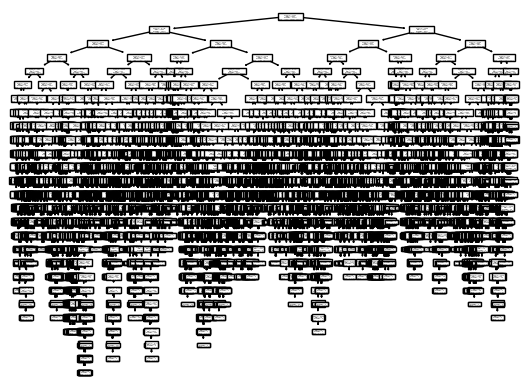

In [7]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)
decision_tree_classifier_predictions = decision_tree_classifier.predict(X_val)
plot_tree(decision_tree_classifier)
print(classification_report(y_val, decision_tree_classifier_predictions))

### [Extra tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#extratreeclassifier)

              precision    recall  f1-score   support

           0       0.36      0.37      0.37      1556
           1       0.46      0.46      0.46      2248
           2       0.42      0.41      0.41      1691

    accuracy                           0.42      5495
   macro avg       0.41      0.41      0.41      5495
weighted avg       0.42      0.42      0.42      5495



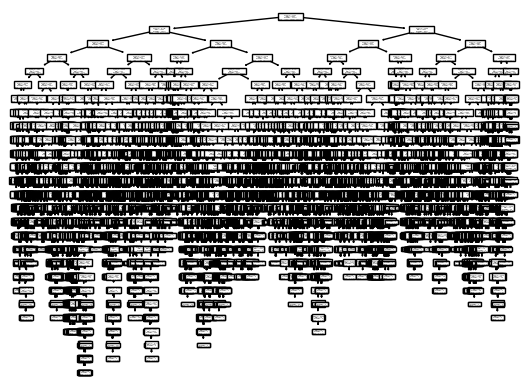

In [8]:
extra_tree_classifier = ExtraTreeClassifier()
extra_tree_classifier.fit(X_train, y_train)
extra_tree_classifier_predictions = extra_tree_classifier.predict(X_val)
plot_tree(decision_tree_classifier)
print(classification_report(y_val, extra_tree_classifier_predictions))

## [Ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html#ensembles-gradient-boosting-random-forests-bagging-voting-stacking)

[API reference](https://scikit-learn.org/stable/api/sklearn.ensemble.html)

### [Randomised tree ensembles](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)

#### [Random forest classifier](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)

In [9]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train, y_train)
random_forest_classifier_predictions = random_forest_classifier.predict(X_val)
print(classification_report(y_val, random_forest_classifier_predictions))


              precision    recall  f1-score   support

           0       0.64      0.41      0.50      1556
           1       0.54      0.77      0.64      2248
           2       0.69      0.54      0.61      1691

    accuracy                           0.60      5495
   macro avg       0.63      0.57      0.58      5495
weighted avg       0.62      0.60      0.59      5495



#### [Extremely randomized trees classifier](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)

In [10]:
extra_trees_classifier = ExtraTreesClassifier()
extra_trees_classifier.fit(X_train, y_train)
extra_trees_classifier_predictions = extra_trees_classifier.predict(X_val)
print(classification_report(y_val, extra_trees_classifier_predictions))


              precision    recall  f1-score   support

           0       0.64      0.40      0.50      1556
           1       0.54      0.77      0.63      2248
           2       0.69      0.53      0.60      1691

    accuracy                           0.59      5495
   macro avg       0.62      0.57      0.58      5495
weighted avg       0.61      0.59      0.58      5495



### [Gradient boosted trees](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees)

#### [Gradient boosted decision trees](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees)

In [11]:
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train, y_train)
gradient_boosting_classifier_predictions = gradient_boosting_classifier.predict(X_val)
print(classification_report(y_val, gradient_boosting_classifier_predictions))


              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1556
           1       0.59      0.70      0.64      2248
           2       0.69      0.62      0.66      1691

    accuracy                           0.63      5495
   macro avg       0.64      0.62      0.63      5495
weighted avg       0.63      0.63      0.63      5495



#### [Histogram gradient boosted decision trees](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)

In [12]:
hist_gradient_boosting_classifier = HistGradientBoostingClassifier()
hist_gradient_boosting_classifier.fit(X_train, y_train)
hist_gradient_boosting_classifier_predictions = hist_gradient_boosting_classifier.predict(X_val)
print(classification_report(y_val, hist_gradient_boosting_classifier_predictions))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59      1556
           1       0.60      0.70      0.64      2248
           2       0.71      0.65      0.68      1691

    accuracy                           0.64      5495
   macro avg       0.65      0.63      0.64      5495
weighted avg       0.65      0.64      0.64      5495



### Other combined methods

#### [Bagging meta estimator classifier](https://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator)

In [13]:
bagging_classifier = BaggingClassifier()
bagging_classifier.fit(X_train, y_train)
bagging_classifier_predictions = bagging_classifier.predict(X_val)
print(classification_report(y_val, bagging_classifier_predictions))

              precision    recall  f1-score   support

           0       0.46      0.47      0.46      1556
           1       0.51      0.57      0.54      2248
           2       0.59      0.49      0.54      1691

    accuracy                           0.52      5495
   macro avg       0.52      0.51      0.51      5495
weighted avg       0.52      0.52      0.52      5495



#### [Voting classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

In [14]:
voting_classifier = VotingClassifier(estimators=[('et', extra_trees_classifier),
                                                 ('gb', gradient_boosting_classifier)])
voting_classifier.fit(X_train, y_train)
vote_classifier_predictions = voting_classifier.predict(X_val)
print(classification_report(y_val, vote_classifier_predictions))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1556
           1       0.56      0.72      0.63      2248
           2       0.78      0.48      0.59      1691

    accuracy                           0.61      5495
   macro avg       0.65      0.60      0.61      5495
weighted avg       0.64      0.61      0.61      5495



#### [Stacked generalisation classifier](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization)

In [15]:
stacking_classifier = StackingClassifier(estimators=[('et', extra_trees_classifier),
                                                     ('gb', gradient_boosting_classifier)],
                                         final_estimator=RandomForestClassifier())
stacking_classifier.fit(X_train, y_train)
stacking_classifier_predictions = stacking_classifier.predict(X_val)
print(classification_report(y_val, stacking_classifier_predictions))

              precision    recall  f1-score   support

           0       0.60      0.55      0.57      1556
           1       0.58      0.64      0.61      2248
           2       0.66      0.63      0.64      1691

    accuracy                           0.61      5495
   macro avg       0.62      0.61      0.61      5495
weighted avg       0.61      0.61      0.61      5495



#### [Isolation forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [16]:
isolated_forest_classifier = IsolationForest()
isolated_forest_classifier.fit(X_train)
isolated_forest_predictions = isolated_forest_classifier.predict(X_val)
print(classification_report(y_val, isolated_forest_predictions))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1556
           1       0.40      0.93      0.56      2248
           2       0.00      0.00      0.00      1691

    accuracy                           0.38      5495
   macro avg       0.10      0.23      0.14      5495
weighted avg       0.17      0.38      0.23      5495



/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

### Advanced boosting algorithms

#### [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

In [17]:
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train, y_train)
adaboost_classifier_predictions = adaboost_classifier.predict(X_val)
print(classification_report(y_val, adaboost_classifier_predictions))

              precision    recall  f1-score   support

           0       0.54      0.42      0.47      1556
           1       0.53      0.63      0.57      2248
           2       0.60      0.58      0.59      1691

    accuracy                           0.55      5495
   macro avg       0.56      0.54      0.54      5495
weighted avg       0.55      0.55      0.55      5495



#### [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)

In [18]:
xgboost_classifier = XGBClassifier(tree_method="hist", device="cuda", n_jobs=-1)
xgboost_classifier.fit(X_train, y_train)
xgboost_classifier_predictions = xgboost_classifier.predict(X_val)
print(classification_report(y_val, xgboost_classifier_predictions))


              precision    recall  f1-score   support

           0       0.64      0.56      0.60      1556
           1       0.60      0.69      0.64      2248
           2       0.71      0.65      0.68      1691

    accuracy                           0.64      5495
   macro avg       0.65      0.63      0.64      5495
weighted avg       0.64      0.64      0.64      5495



/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:47:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#### [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

In [19]:
lightgbm_classifier = LGBMClassifier(device="gpu", n_jobs=-1)
lightgbm_classifier.fit(X_train, y_train)
lightgbm_classifier_predictions = lightgbm_classifier.predict(X_val)
print(classification_report(y_val, lightgbm_classifier_predictions))


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 21983, number of used features: 300
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 300 dense feature groups (6.29 MB) transferred to GPU in 0.009349 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.261857
[LightGBM] [Info] Start training from score -0.907820
[LightGBM] [Info] Start training from score -1.160053
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      1556
           1       0.60      0.70      0.65      2248
           2       0.71      0.65      0.68      1691

    accuracy                           0.64      5495
   macro avg       0.65      0.64

/home/nixosuser/cs4248-tweet-sentiment-analysis/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### [CatBoost](https://catboost.ai/docs/en/)

In [20]:
catboost_classifier = CatBoostClassifier(task_type="GPU")
catboost_classifier.fit(X_train, y_train)
catboost_classifier_predictions = catboost_classifier.predict(X_val)
print(classification_report(y_val, catboost_classifier_predictions))


Learning rate set to 0.121918
0:	learn: 1.0789077	total: 79.6ms	remaining: 1m 19s
1:	learn: 1.0630981	total: 96.6ms	remaining: 48.2s
2:	learn: 1.0482000	total: 114ms	remaining: 38s
3:	learn: 1.0354630	total: 131ms	remaining: 32.7s
4:	learn: 1.0244072	total: 149ms	remaining: 29.6s
5:	learn: 1.0143876	total: 167ms	remaining: 27.6s
6:	learn: 1.0048417	total: 183ms	remaining: 26s
7:	learn: 0.9961300	total: 200ms	remaining: 24.8s
8:	learn: 0.9881516	total: 217ms	remaining: 23.9s
9:	learn: 0.9803524	total: 232ms	remaining: 23s
10:	learn: 0.9732192	total: 245ms	remaining: 22.1s
11:	learn: 0.9670983	total: 258ms	remaining: 21.3s
12:	learn: 0.9610924	total: 272ms	remaining: 20.6s
13:	learn: 0.9554781	total: 284ms	remaining: 20s
14:	learn: 0.9500991	total: 297ms	remaining: 19.5s
15:	learn: 0.9451362	total: 310ms	remaining: 19.1s
16:	learn: 0.9400717	total: 323ms	remaining: 18.7s
17:	learn: 0.9356623	total: 336ms	remaining: 18.3s
18:	learn: 0.9310643	total: 349ms	remaining: 18s
19:	learn: 0.92671

#### [NGBoost](https://stanfordmlgroup.github.io/ngboost/intro.html)

In [21]:
ngboost_classifier = NGBClassifier(Dist=k_categorical(3))
ngboost_classifier.fit(X_train, y_train)
ngboost_classifier_predictions = ngboost_classifier.predict(X_val)
print(classification_report(y_val, ngboost_classifier_predictions))

[iter 0] loss=1.0871 val_loss=0.0000 scale=1.0000 norm=3.4142
[iter 100] loss=0.9952 val_loss=0.0000 scale=1.0000 norm=3.1553
[iter 200] loss=0.9433 val_loss=0.0000 scale=1.0000 norm=3.0476
[iter 300] loss=0.9078 val_loss=0.0000 scale=1.0000 norm=2.9877
[iter 400] loss=0.8808 val_loss=0.0000 scale=1.0000 norm=2.9475
              precision    recall  f1-score   support

           0       0.68      0.34      0.45      1556
           1       0.52      0.76      0.62      2248
           2       0.64      0.55      0.59      1691

    accuracy                           0.58      5495
   macro avg       0.62      0.55      0.56      5495
weighted avg       0.60      0.58      0.57      5495



## Load test data

In [23]:
test_df = pd.read_csv("data/test_preprocessed.csv")
print("Test set size: " + str(len(test_df)))

# X_test = vectorizer.transform(test_set["lemmatized_sentence"])
# X_test = torch.Tensor(X_test.todense())

# Process test set using the GloVe embeddings
X_test = np.array([document_vector(doc.split(), glove_vectors) 
                  for doc in tqdm(test_df["lemmatized_sentence"], desc="Processing test data")])

Test set size: 3534


Processing test data: 100%|██████████| 3534/3534 [00:00<00:00, 26214.82it/s]


## Evaluate models

In [25]:
reverse_label_map = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

# decision_tree_classifier_predictions = decision_tree_classifier.predict(X_test)
# extra_tree_classifier_predictions = extra_tree_classifier.predict(X_test)
# random_forest_classifier_predictions = random_forest_classifier.predict(X_test)
# extra_trees_classifier_predictions = extra_trees_classifier.predict(X_test)
# gradient_boosting_classifier_predictions = gradient_boosting_classifier.predict(X_test)
hist_gradient_boosting_classifier_predictions = hist_gradient_boosting_classifier.predict(X_test)
# bagging_classifier_predictions = bagging_classifier.predict(X_test)
# voting_classifier_predictions = voting_classifier.predict(X_test)
# stacking_classifier_predictions = stacking_classifier.predict(X_test)
# isolated_forest_predictions = isolated_forest_classifier.predict(X_test)
# adaboost_classifier_predictions = adaboost_classifier.predict(X_test)
# xgboost_classifier_predictions = xgboost_classifier.predict(X_test)
# lightgbm_classifier_predictions = lightgbm_classifier.predict(X_test)
# catboost_classifier_predictions = catboost_classifier.predict(X_test)
# ngboost_classifier_predictions = ngboost_classifier.predict(X_test)

predictions_to_save = hist_gradient_boosting_classifier_predictions
mapped_predictions = np.array([reverse_label_map[prediction] for prediction in predictions_to_save])
test_df["predicted_sentiment"] = mapped_predictions
test_df.to_csv("data/tree_model_predictions.csv", index=False)

test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),expanded_text,clean_text,text_without_stopwords,tokens,lemmatized_tokens,lemmatized_sentence,label,predicted_sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,Last session of the day http://twitpic.com/67ezh,last session of the day httptwitpiccom ezh,last session day httptwitpiccom ezh,"['last', 'session', 'of', 'the', 'day', 'httpt...","['last', 'session', 'of', 'the', 'day', 'httpt...",last session of the day httptwitpiccom ezh,1,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,Shanghai is also really exciting (precisely -...,shanghai is also really exciting precisely sky...,shanghai also really exciting precisely skyscr...,"['shanghai', 'is', 'also', 'really', 'exciting...","['shanghai', 'be', 'also', 'really', 'excite',...",shanghai be also really excite precisely skysc...,2,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,"Recession hit Veronique Branquinho, she has to...",recession hit veronique branquinho she has to ...,recession hit veronique branquinho quit compan...,"['recession', 'hit', 'veronique', 'branquinho'...","['recession', 'hit', 'veronique', 'branquinho'...",recession hit veronique branquinho she have to...,0,negative
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy birthday!,happy birthday,happy birthday,"['happy', 'birthday']","['happy', 'birthday']",happy birthday,2,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,http://twitpic.com/4w75p - I like it!!,httptwitpiccom w p i like it,httptwitpiccom w p like,"['httptwitpiccom', 'w', 'p', 'i', 'like', 'it']","['httptwitpiccom', 'w', 'p', 'i', 'like', 'it']",httptwitpiccom w p i like it,2,neutral
